In [1]:
from sklearn.ensemble import (
    StackingClassifier, 
    RandomForestClassifier,
    AdaBoostClassifier
)
from sklearn.model_selection import (train_test_split, GridSearchCV)
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier

import lucem_illud
import numpy as np
import pandas as pd
import regex as re

from nltk.stem import WordNetLemmatizer
from nltk.tag import pos_tag
import nltk.downloader
from nltk.corpus import wordnet

import matplotlib.pyplot as plt

nltk.downloader.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\wimer\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

# Based on text

In [2]:
# TODO: Apply topic model on each type of grade--

def find_common_words(df, column='normalized_tokens', nwords=20):
    full_text = ""
    for _, row in df.iterrows():
        full_text = full_text + " " + ' '.join(row[column])

    allWords = nltk.tokenize.word_tokenize(full_text)
    allWordDist = nltk.FreqDist(w.lower() for w in allWords)
    
    mostCommon= allWordDist.most_common(nwords)
    
    return mostCommon, allWordDist

def get_wordnet_pos(treebank_tag):
    '''
    pos_tag uses the treebank tag system, but we need things in the wordnet
    system. This function handles the conversion
    '''
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    
    if treebank_tag.startswith('V'):
        return wordnet.VERB
    
    if treebank_tag.startswith('N'):
        return wordnet.NOUN
    
    if treebank_tag.startswith('R'):
        return wordnet.ADV
    
    return ''

def drop_bad(token_lst, add_stop_words=[], vocab_lst = set()):
    '''
    Exclude one letter tokens, all numerics.
    '''
    rv = []

    pos_lst = pos_tag(token_lst)
    pos_lst = [(token, get_wordnet_pos(pos)) for (token, pos) in pos_lst
               if get_wordnet_pos(pos)]

    lemmatizer = WordNetLemmatizer()
    for token, pos in pos_lst:

        if not pos:
            continue
        
        if len(token) <= 2:
            continue

        if re.search(r"[0-9]+", token):
            continue

        if token in add_stop_words:
            continue
        
        if not token in vocab_lst and vocab_lst:
            continue

        rv.append(lemmatizer.lemmatize(token, pos))
    
    return rv




In [3]:
tm_data = pd.read_json('../data/shapes/ad_data.json')[['area_id', 'selected_fields', 'grade']]

tm_data['tokenized_text'] = tm_data['selected_fields'].apply(
    lambda x: lucem_illud.word_tokenize(x)
)

tm_data['normalized_tokens'] = tm_data['tokenized_text'].apply(
    lambda x: lucem_illud.normalizeTokens(x)
)

tm_data.head()

C:\Users\wimer\AppData\Roaming\Python\Python311\site-packages\spacy\pipeline\lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


,area_id,selected_fields,grade,tokenized_text,normalized_tokens
0,3948,"These 6 areas contain about 35 houses, practic...",A,"[These, 6, areas, contain, about, 35, houses, ...","[areas, contain, houses, practically, modern, ..."
1,3929,"These 6 areas contain about 35 houses, practic...",A,"[These, 6, areas, contain, about, 35, houses, ...","[areas, contain, houses, practically, modern, ..."
2,3926,"These 6 areas contain about 35 houses, practic...",A,"[These, 6, areas, contain, about, 35, houses, ...","[areas, contain, houses, practically, modern, ..."
3,7175,"These 6 areas contain about 35 houses, practic...",A,"[These, 6, areas, contain, about, 35, houses, ...","[areas, contain, houses, practically, modern, ..."
4,3938,"These 6 areas contain about 35 houses, practic...",A,"[These, 6, areas, contain, about, 35, houses, ...","[areas, contain, houses, practically, modern, ..."


In [4]:

tm_data['reduced_words'] = tm_data['normalized_tokens'].apply(drop_bad)

common_words, words_dist = find_common_words(tm_data, 'reduced_words', nwords=150)
words = [w for w, _ in common_words]
freqs = [f for _, f in common_words]

vocab = set()
for word, count in list(words_dist.most_common())[52:]:
    if count > 100:
        vocab.add(word)

ADD_STOP = ['avenue', 'blvd', 'lot', 'street', 'cent', 'road']
tm_data['rreduced_words'] = tm_data['reduced_words'].apply(lambda x: drop_bad(x, add_stop_words=ADD_STOP, vocab_lst=vocab))
tm_data.head()

,area_id,selected_fields,grade,tokenized_text,normalized_tokens,reduced_words,rreduced_words
0,3948,"These 6 areas contain about 35 houses, practic...",A,"[These, 6, areas, contain, about, 35, houses, ...","[areas, contain, houses, practically, modern, ...","[area, contain, house, practically, modern, co...","[contain, practically, modern, elevate, princi..."
1,3929,"These 6 areas contain about 35 houses, practic...",A,"[These, 6, areas, contain, about, 35, houses, ...","[areas, contain, houses, practically, modern, ...","[area, contain, house, practically, modern, co...","[contain, practically, modern, elevate, princi..."
2,3926,"These 6 areas contain about 35 houses, practic...",A,"[These, 6, areas, contain, about, 35, houses, ...","[areas, contain, houses, practically, modern, ...","[area, contain, house, practically, modern, co...","[contain, practically, modern, elevate, princi..."
3,7175,"These 6 areas contain about 35 houses, practic...",A,"[These, 6, areas, contain, about, 35, houses, ...","[areas, contain, houses, practically, modern, ...","[area, contain, house, practically, modern, co...","[contain, practically, modern, elevate, princi..."
4,3938,"These 6 areas contain about 35 houses, practic...",A,"[These, 6, areas, contain, about, 35, houses, ...","[areas, contain, houses, practically, modern, ...","[area, contain, house, practically, modern, co...","[contain, practically, modern, elevate, princi..."


In [5]:
tm_data['reduced_docs'] = tm_data.rreduced_words.apply(lambda x: ' '.join(x))

In [6]:
stacker = StackingClassifier(
    estimators = [
        ('lrcv', LogisticRegression(max_iter=1500, penalty='l2', solver='sag')),
        ('svm', SVC(probability=True)),
        ('rfc', RandomForestClassifier()),
        ('abc', AdaBoostClassifier()),
        ('gnb', Pipeline([
            ('to_dense', FunctionTransformer(lambda x: x.toarray(), accept_sparse=True)),
             ('gnb', GaussianNB())
        ]))
    ],
    final_estimator=LogisticRegression(max_iter=1000)
)


model = Pipeline(
    [
        ('tfidf', TfidfVectorizer(dtype=np.float32)),
        ('stacker', stacker)
    ]
)

model

Pipeline(steps=[('tfidf', TfidfVectorizer(dtype=<class 'numpy.float32'>)),
                ('stacker',
                 StackingClassifier(estimators=[('lrcv',
                                                 LogisticRegression(max_iter=1500,
                                                                    solver='sag')),
                                                ('svm', SVC(probability=True)),
                                                ('rfc',
                                                 RandomForestClassifier()),
                                                ('abc', AdaBoostClassifier()),
                                                ('gnb',
                                                 Pipeline(steps=[('to_dense',
                                                                  FunctionTransformer(accept_sparse=True,
                                                                                      func=<function <lambda> at 0x0000027BEB6D93A0>)),
                                                                 ('gnb',
                                                                  GaussianNB())]))],
                                    final_estimator=LogisticRegression(max_iter=1000)))])

In [7]:
model_tm_data = tm_data.copy()[(tm_data.reduced_docs != '') & (~tm_data.grade.isna())]

In [8]:
# Currently training on a few duplicate metadata entries
train_test = model_tm_data.copy().drop_duplicates(['reduced_docs', 'grade'])
X_train, X_test, y_train, y_test = train_test_split(train_test.reduced_docs, 
                                                    train_test.grade, random_state=42)

model.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer(dtype=<class 'numpy.float32'>)),
                ('stacker',
                 StackingClassifier(estimators=[('lrcv',
                                                 LogisticRegression(max_iter=1500,
                                                                    solver='sag')),
                                                ('svm', SVC(probability=True)),
                                                ('rfc',
                                                 RandomForestClassifier()),
                                                ('abc', AdaBoostClassifier()),
                                                ('gnb',
                                                 Pipeline(steps=[('to_dense',
                                                                  FunctionTransformer(accept_sparse=True,
                                                                                      func=<function <lambda> at 0x0000027BEB6D93A0>)),
                                                                 ('gnb',
                                                                  GaussianNB())]))],
                                    final_estimator=LogisticRegression(max_iter=1000)))])

In [9]:
model.score(X_test, y_test)

0.7287699433865157

### What are the relevant predictors? I just realized I don't have the packages for that lol

#### Let's plot propensity diffs instead ig

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
train_test.head()

,area_id,selected_fields,grade,tokenized_text,normalized_tokens,reduced_words,rreduced_words,reduced_docs
0,3948,"These 6 areas contain about 35 houses, practic...",A,"[These, 6, areas, contain, about, 35, houses, ...","[areas, contain, houses, practically, modern, ...","[area, contain, house, practically, modern, co...","[contain, practically, modern, elevate, princi...",contain practically modern elevate principal s...
6,3949,These two areas contain about 70 houses. There...,B,"[These, two, areas, contain, about, 70, houses...","[areas, contain, houses, older, grade, propert...","[area, contain, house, old, grade, property, p...","[contain, poorer, repair, remain, eastern, wes...",contain poorer repair remain eastern western g...
7,3935,These six areas contain about 175 houses. In t...,B,"[These, six, areas, contain, about, 175, house...","[areas, contain, houses, eastern, portion, b-3...","[area, contain, house, eastern, portion, weste...","[contain, eastern, western, poorer, repair, co...",contain eastern western poorer repair conditio...
8,3934,These six areas contain about 175 houses. In t...,B,"[These, six, areas, contain, about, 175, house...","[areas, contain, houses, eastern, portion, b-3...","[area, contain, house, eastern, portion, weste...","[contain, eastern, western, poorer, repair, co...",contain eastern western poorer repair conditio...
13,3939,*Ample mortgage funds are available in this ar...,C,"[Ample, mortgage, funds, are, available, in, t...","[ample, mortgage, funds, available, area, rest...","[ample, mortgage, fund, available, area, restr...","[mortgage, available, restrict, basis, percent...",mortgage available restrict basis percentage c...


In [12]:
# NOTE: model performance may improve if i drop duplicate inputs, which seem to exist 
props = pd.DataFrame(model.predict_proba(model_tm_data.reduced_docs), columns=model.classes_)

model_tm_data_preds = pd.concat([model_tm_data.copy(), props], axis=1)

model_tm_data_preds.head()

,area_id,selected_fields,grade,tokenized_text,normalized_tokens,reduced_words,rreduced_words,reduced_docs,A,B,C,D
0,3948.0,"These 6 areas contain about 35 houses, practic...",A,"[These, 6, areas, contain, about, 35, houses, ...","[areas, contain, houses, practically, modern, ...","[area, contain, house, practically, modern, co...","[contain, practically, modern, elevate, princi...",contain practically modern elevate principal s...,0.283773,0.674489,0.038284,0.003454
1,3929.0,"These 6 areas contain about 35 houses, practic...",A,"[These, 6, areas, contain, about, 35, houses, ...","[areas, contain, houses, practically, modern, ...","[area, contain, house, practically, modern, co...","[contain, practically, modern, elevate, princi...",contain practically modern elevate principal s...,0.283773,0.674489,0.038284,0.003454
2,3926.0,"These 6 areas contain about 35 houses, practic...",A,"[These, 6, areas, contain, about, 35, houses, ...","[areas, contain, houses, practically, modern, ...","[area, contain, house, practically, modern, co...","[contain, practically, modern, elevate, princi...",contain practically modern elevate principal s...,0.283773,0.674489,0.038284,0.003454
3,7175.0,"These 6 areas contain about 35 houses, practic...",A,"[These, 6, areas, contain, about, 35, houses, ...","[areas, contain, houses, practically, modern, ...","[area, contain, house, practically, modern, co...","[contain, practically, modern, elevate, princi...",contain practically modern elevate principal s...,0.283773,0.674489,0.038284,0.003454
4,3938.0,"These 6 areas contain about 35 houses, practic...",A,"[These, 6, areas, contain, about, 35, houses, ...","[areas, contain, houses, practically, modern, ...","[area, contain, house, practically, modern, co...","[contain, practically, modern, elevate, princi...",contain practically modern elevate principal s...,0.283773,0.674489,0.038284,0.003454


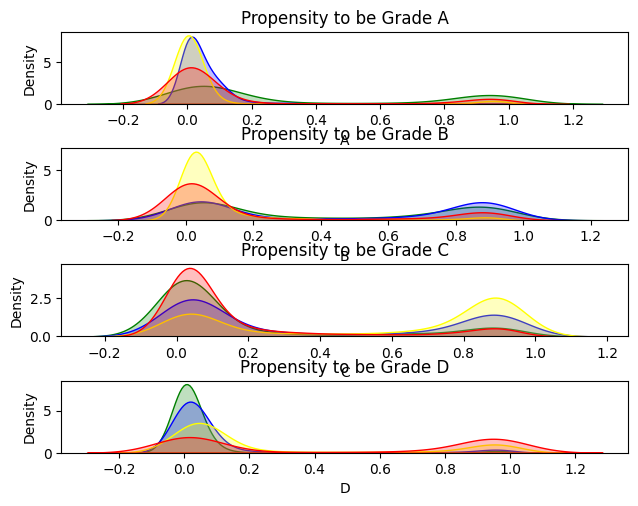

In [13]:

def plot_propensities(df: pd.DataFrame, grade: str, ax=None, 
                      cats=['A','B','C','D'], subset_col='grade', 
                      colors=['green', 'blue', 'yellow', 'red']) -> None:
    '''
    Given a pandas dataframe containing HOLC neighborhoods and their pred.
    propensities for each grade, plot the propensities as a density plot.    
    '''
    if not ax:
        fig, ax = plt.subplots()

    for cat, color in zip(cats, colors):
        sns.kdeplot(df[df[subset_col]==cat][grade], fill=True, color=color, ax=ax)

fig, axes = plt.subplots(ncols=1, nrows=4)
fig.tight_layout()
for ax, grade in zip(axes, ['A', 'B', 'C', 'D']):
    plot_propensities(model_tm_data_preds, grade, ax)
    ax.set_title(f'Propensity to be Grade {grade}')

In [14]:
train_test['AB'] = train_test['grade'].isin(['A','B'])

train_test['AB']

0        True
6        True
7        True
8        True
13      False
        ...  
7925    False
7926    False
7927    False
7928    False
7929    False
Name: AB, Length: 7772, dtype: bool

In [15]:
X_train, X_test, y_train, y_test = train_test_split(train_test.reduced_docs, train_test.AB, random_state=42)

model.fit(X_train, y_train)

model.score(X_test, y_test)

0.8970663921770458

In [16]:
# NOTE: model performance may improve if i drop duplicate inputs, which seem to exist 
props = pd.DataFrame(model.predict_proba(model_tm_data.reduced_docs), columns=model.classes_)

model_tm_data_preds = pd.concat([model_tm_data.copy(), props], axis=1, ignore_index=True)

In [17]:
model_tm_data = model_tm_data.reset_index(drop=True)

In [18]:
model_tm_data['propCD'] = props.iloc[:, 0]
model_tm_data['propAB'] = props.iloc[:, 1]

<Axes: xlabel='propAB', ylabel='Density'>

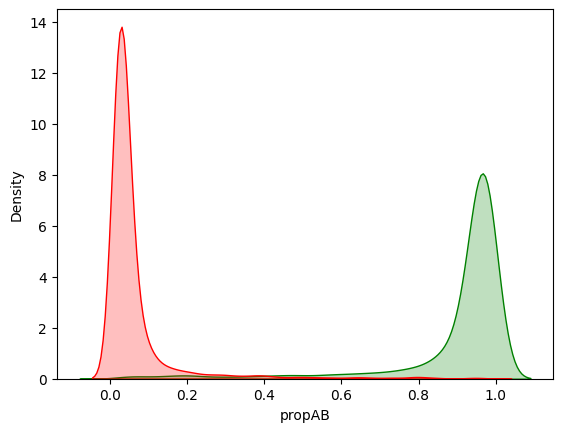

In [19]:
fig, ax = plt.subplots()
sns.kdeplot((model_tm_data[model_tm_data['grade'].isin(['A', 'B'])]['propAB']), ax=ax, color='green', fill=True)
sns.kdeplot((model_tm_data[model_tm_data['grade'].isin(['C', 'D'])]['propAB']), ax=ax, color='red', fill=True)


In [24]:
(X_train_shap, 5)

array(<shap.utils._legacy.DenseData object at 0x0000027BE56CF590>,
      dtype=object)

In [117]:
import shap

X_train_shap = model['tfidf'].transform(X_train)

explainer = shap.Explainer(model['stacker'].predict_proba, 
                                 shap.sample(X_train, 5))

explainer = shap.Explainer(model.predict_proba, shap.sample(X_train.reset_index(drop=True), 5))

In [119]:
X_test.reset_index(drop=True)

0       hold market depression employ domestic desirab...
1       vicinity university northern far steep hill ol...
2       remote industry restriction labor polish locat...
3       hilly highly protect restrict adequate utility...
4       slightly shade valley lay add charm appeal cou...
                              ...                        
1938    flat industry sidewalk gas water sewer dirt sm...
1939                                exception russian yes
1940    hilly proximity commercial industrial employme...
1941    junior executive collar know hill wooded terra...
1942    fairly flat attractive convenient location exe...
Name: reduced_docs, Length: 1943, dtype: object

In [118]:
shap_values = explainer(X_test.reset_index(drop=True))

IndexError: tuple index out of range

In [89]:
shap_values[0][0]

array([0., 0.])

In [82]:
explainer.expected_value

array([0.6242263, 0.3757737])

array(['stackingclassifier_lrcv', 'stackingclassifier_svm',
       'stackingclassifier_rfc', 'stackingclassifier_abc',
       'stackingclassifier_gnb'], dtype=object)

In [168]:
vecotrizer = model.named_steps['tfidf']
X_train_transformed = vecotrizer.transform(X_train.sample(50))
X_test_transformed = vecotrizer.transform(X_test[:10])

explainer = shap.KernelExplainer(model.named_steps['stacker'].predict_proba,
                           X_train_transformed, 
                           feature_names=sorted(vecotrizer.vocabulary_.keys(), 
                                                key=vecotrizer.vocabulary_.get))

shap_values = explainer.shap_values(X_test_transformed, 
                                    feature_names=sorted(vecotrizer.vocabulary_.keys(), key=vecotrizer.vocabulary_.get))

100%|██████████| 10/10 [8:08:55<00:00, 2933.52s/it] 


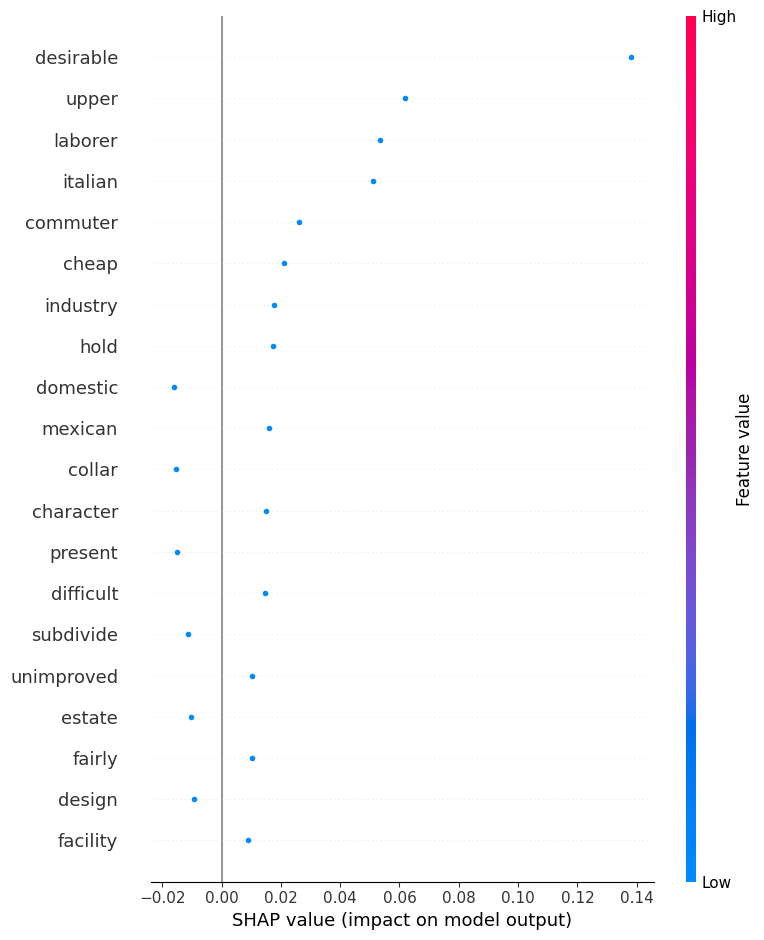

In [161]:
shap.initjs()
shap.summary_plot(shap_values[:, :, 1], X_test_transformed.toarray(), feature_names=vecotrizer.get_feature_names_out())

In [ ]:
from sklearn.linear_model import Lasso

# numeric data